In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, TimeDistributed
from keras.utils import to_categorical

from sys import stdout
import os

Using TensorFlow backend.


In [0]:
from time import time
from datetime import datetime


class TimeExpector:
    def __init__(self):
        self._last_time_length = None
        self.tick_tock_check = False
        self.t_start = None

    @staticmethod
    def time_unit_creator(l_time):
        time_unit = 'seconds'
        if l_time >= 60:
            l_time /= 60
            time_unit = 'minutes'
        else:
            return l_time, time_unit

        if l_time >= 60:
            l_time /= 60
            time_unit = 'hours'
        else:
            return l_time, time_unit

        if l_time >= 24:
            l_time /= 24
            time_unit = 'days'
        else:
            return l_time, time_unit

        if l_time >= 30:
            l_time /= 30
            time_unit = 'month'
            return l_time, time_unit
        else:
            return l_time, time_unit

    def tick(self, iteration_left=None, reset=False):
        if self.tick_tock_check:
            print('[WARNING] calling "tick" without a "tock"...')

        if reset:
            self._last_time_length = None
        self.t_start = time()

        if self._last_time_length is not None:
            expectation = self.t_start
            if iteration_left is not None:
                expectation +=  self._last_time_length * iteration_left
            else:
                expectation +=  self._last_time_length
            datestr = datetime.fromtimestamp(expectation).strftime("%Y-%m-%d %H:%M:%S")
            print('[expecting to finish at %s]' % datestr)
        self.tick_tock_check = True

    def tock(self):
        if not self.tick_tock_check:
            print('[WARNING] calling "tock" without a "tick"...')

        self.tick_tock_check = False
        length = time() - self.t_start

        if self._last_time_length is None:
            self._last_time_length = length
        else:
            self._last_time_length = .9 * self._last_time_length + .1 * length

        length, length_unit = self.time_unit_creator(length)
        print('[operation finished at %s  -  took %d %s]' % (
            datetime.fromtimestamp(time()).strftime("%Y-%m-%d %H:%M:%S"), length, length_unit))


In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*- 

import os
import requests


_URL = os.environ.get('NOTIFY_URL', None)
_SLACK_NOTIFY = _URL is not None


def notify(*msgs, **kwargs):
    mark = kwargs.get('mark', None)
    title = kwargs.get('title', None)
    channel = kwargs.get('channel', None)
    icon = kwargs.get('icon', None)

    if mark is None:
        pass
    elif mark == 'info':
        mark = 'ℹ️'
    elif mark == 'error':
        mark = '📛'
    elif mark == 'ok':
        mark = '✅'
    elif mark == 'warn' or mark == 'warning':
        mark = '⚠️'
    elif mark == 'heart':
        mark = '🧡'
    else:
        mark = '[%s]' % mark

    msg = '' if mark is None else ('%s ' % mark)
    msg += '  '.join([str(m) for m in msgs])
    if title is not None:
        print('%s) \t%s' % (title, msg))
    else:
        print(msg)
    if not _SLACK_NOTIFY:
        return

    data = {
        'text': msg
    }
    if channel is not None:
        data['channel'] = '#%s' % channel
    if title is not None:
        data['name'] = title
    if icon is not None:
        data['icon'] = ':%s:' % icon

    try:
        requests.post(_URL, json=data)
    except:
        print('     can not write to channel...')



if __name__ == "__main__":
    notify('test message')
    notify('and a message with everything', mark='heart', icon='ghost', channel='general', title='wonderful')



test message
wonderful) 	🧡 and a message with everything


In [0]:
# Data Reader

import struct
from collections import OrderedDict

DEBUG_PRINT = False


class EOF(Exception):
    pass


def read_file(f, size, unpack_type=None):
    d = f.read(size)
    if d == '':
        raise EOF()
    if unpack_type is None:
        unpack_type = 'H' if size == 2 else 'I'
    return struct.unpack(unpack_type, d)[0]


def skip_file_header(f):
    line_counter = 0
    line = '#'
    while line.startswith('#') and not line.startswith('#!END-HEADER'):
        line = f.readline()


def read_header(f):
    header = OrderedDict([
        ('eventType', read_file(f, 2)),
        ('eventSource', read_file(f, 2)),
        ('eventSize', read_file(f, 4)),
        ('eventTSOffset', read_file(f, 4)),
        ('eventTSOverflow', read_file(f, 4)),
        ('eventCapacity', read_file(f, 4)),
        ('eventNumber', read_file(f, 4)),
        ('eventValid', read_file(f, 4)),
    ])
    return header


def read_event(f, timestamp_offset):
    data = read_file(f, 4)
    timestamp = read_file(f, 4, 'i')
    x = (data >> 17) & 0x00001FFF
    y = (data >> 2) & 0x00001FFF
    polarity = (data >> 1) & 0x00000001
    return {
        'x': x,
        'y': y,
        'polarity': polarity,
        'timestamp': timestamp + timestamp_offset * 2**31,
        'data': data,
    }


def load_dataset(file_path):
    event_list = []
    with open(file_path, 'rb') as f:
        skip_file_header(f)
        
        while True:
            try:
                header = read_header(f)
                if DEBUG_PRINT:
                    for k, v in header.items():
                        print('%15s:  %d' % (k, v))
                    print('--------------------------')

                event_number = header['eventNumber']
                for i in range(event_number):
                    event = read_event(f, header['eventTSOffset'])
                    event_list.append(event)
                event_list.append('clear')
            except EOF:
                break
    return event_list


def read_file_all(file_name):
    if DEBUG_PRINT:
        print('loading dataset...')
    event_list = load_dataset(file_name)
    if DEBUG_PRINT:
        print('done!')
    return event_list



In [0]:
import numpy as np
import os
from collections import OrderedDict


ORIGINAL_IMAGE_HEIGHT = 128
ORIGINAL_IMAGE_WIDTH = 128

GESTURE_MAPPING = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}


def get_label(event_labels, timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0


def get_label_text(event_labels, timestamp):
    return GESTURE_MAPPING[get_label(event_labels, timestamp)]


def load_trail_files(trail_file, dataset_folder_path):
    file_list = []
    with open(os.path.join(dataset_folder_path, trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(dataset_folder_path, aedat_file),
                os.path.join(dataset_folder_path, csv_file)
            ))
    return file_list


def read_event_labels(path):
    label_began_time = None
    event_labels = OrderedDict()
    with open(path, 'r') as f:
        for line in f.readlines():
            label, start, end = line.strip().split(',')
            try:
                label = int(label)
                start = int(start)
                end = int(end)
            except ValueError:
                continue
            if label_began_time is None:
                label_began_time = start

            event_labels[start] = 0
            event_labels[end] = label
    return event_labels, label_began_time


def serialize_events(x_data, y_data, ev_times, image_reduce_factor, frame_length_us):
    x_train = []
    y_train = []

    frames = 0
    max_time = np.max(ev_times)
    current_time = np.min(ev_times)

    while current_time < max_time:
        ev_lb = ev_times > current_time
        ev_ub = ev_times < (current_time + frame_length_us)

        event_x = x_data[ev_lb & ev_ub, :]
        event_y = y_data[ev_lb & ev_ub]

        desired_width = ORIGINAL_IMAGE_WIDTH / image_reduce_factor
        desired_height = ORIGINAL_IMAGE_HEIGHT / image_reduce_factor

        retina = np.zeros([desired_width, desired_height])
        retina[event_x[:, 1] / image_reduce_factor, event_x[:, 0] / image_reduce_factor] = 1

        frame_y = np.round(np.mean(event_y))
        current_time += frame_length_us

        frames += 1
        x_train.append(retina.flatten())
        y_train.append(frame_y)

    return np.array(x_train), np.array(y_train)


def read_and_process_file(file_name, trail, counter, image_reduce_factor, frame_length_us, output_data_path):
    ev_x = []
    ev_y = []
    ev_z = []

    print('---> reading "%s"' % file_name[0])
    event_labels, label_began_time = read_event_labels(file_name[1])
    event_list = read_file_all(file_name[0])

    print('---> pre-processing file...')
    stream_begin_time = None
    stream_end_time = None

    frame_counter = 0
    for e in event_list:
        if e == 'clear':
            frame_counter += 1
            continue

        # calculate time information
        event_time = e['timestamp']
        if stream_begin_time is None:
            stream_begin_time = event_time
        event_corrected_time = event_time - stream_begin_time + label_began_time
        event_label = get_label(event_labels, event_corrected_time)

        # append event
        ev = (e['x'], e['y'])
        ev_x.append(ev)
        ev_y.append(event_label)
        ev_z.append(e['timestamp'])

    print('---> processing file...')
    x_train, y_train = serialize_events(np.array(ev_x), np.array(ev_y), np.array(ev_z), image_reduce_factor,
                                        frame_length_us)

    print('---> saving file...')
    x_train = np.array(x_train, dtype='uint8')
    y_train = np.array(y_train, dtype='uint8')
    np.save(file="%s_%s/x_%s_%d" % (output_data_path, trail, trail, counter), arr=x_train)
    np.save(file="%s_%s/y_%s_%d" % (output_data_path, trail, trail, counter), arr=y_train)


#     return x_train, y_train


def download_dataset(dataset_folder_path):
    print('downloading into "%s"' % dataset_folder_path)
    raise NotImplementedError('can not access data folder.')


def cache_data(trail,
               dataset_folder_path,
               output_data_path,
               image_reduce_factor=2,
               frame_length_us=9900,  # almost the same delay in each frame in the DVS data
               ):
    t = TimeExpector()

    if not os.path.exists(dataset_folder_path):
        download_dataset(dataset_folder_path)
        notify('download complete')

    if not os.path.exists(output_data_path):
        os.mkdir(output_data_path)

    if trail == 'train':
        file_list = load_trail_files('trials_to_train.txt', dataset_folder_path)
    elif trail == 'test':
        file_list = load_trail_files('trials_to_test.txt', dataset_folder_path)

    counter = 0
    for file_name_set in file_list:
        t.tick(iteration_left=len(file_list) - counter)
        counter += 1
        print('     ------------------------- %d out of %d -------------------------' % (counter, len(file_list)))
        read_and_process_file(file_name_set, trail, counter, image_reduce_factor, frame_length_us, output_data_path)
        notify('chunk done: %d / %d' % (counter, len(file_list)))
    notify('all done')


def data_loader(trail, dataset_folder_path, cache_folder_path, condition_limit=None):
    dataset_path = dataset_folder_path + 'cleaned_cache_' + trail
    file_list = load_trail_files('trials_to_%s.txt' % trail, dataset_folder_path)

    for counter, f in enumerate(file_list):
        # FIXME: This line is not satisfactory...
        light_condition = f[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if condition_limit is not None and light_condition not in condition_limit:
            continue

        x_data = np.load(file='%s/x_%s_%d.npy' % (cache_folder_path, trail, counter + 1))
        y_data = np.load(file='%s/y_%s_%d.npy' % (cache_folder_path, trail, counter + 1))

        yield x_data, y_data



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint


def data_augment(*args, **kwargs):
    max_augmentation = kwargs.pop('max_augmentation', 1)
    aug_enabled = kwargs.pop('augmentation', True)
    aug_x_offset = kwargs.pop('aug_x_offset', 10)
    aug_y_offset = kwargs.pop('aug_y_offset', 3)
    aug_frame_offset = kwargs.pop('aug_f_offset', 10)
    frame = kwargs.pop('frame', 100)

    for data_x, data_y in data_loader(*args, **kwargs):
        label_histogram = {i: 0 for i in GESTURE_MAPPING.keys()}
        max_hist = None
        output_x = []
        output_y = []

        last_label = None
        buffer_x = []

        # here we augment data until all classes have the same amount of data
        while max_hist is None or any([i < max_hist for _, i in label_histogram.items()]):
            if aug_enabled and max_hist is not None:
                x_offset = randint(-aug_x_offset, aug_x_offset)
                y_offset = randint(-aug_y_offset, aug_y_offset)
                frame_offset = randint(0, aug_frame_offset)
            else:
                x_offset = 0
                y_offset = 0
                frame_offset = 0

            for i in range(frame_offset, data_x.shape[0]):
                current_x = np.reshape(data_x[i], (64, 64))
                current_y = data_y[i]

                # image augmentation
                current_x = np.roll(current_x, x_offset, axis=0)
                current_x = np.roll(current_x, y_offset, axis=1)

                if last_label is None:
                    last_label = current_y
                elif len(buffer_x) >= frame:
                    if max_hist is None or label_histogram[current_y] < max_hist:
                        output_x.append(np.array(buffer_x))
                        output_y.append(current_y)
                        label_histogram[current_y] += 1
                    buffer_x = []
                elif last_label != current_y:
                    buffer_x = []
                    last_label = current_y
                buffer_x.append(current_x)

            # if the augmentation is false, then we ignore adding any more data
            if not aug_enabled:
                break

            if max_hist is None:
                max_hist = label_histogram[max(label_histogram, key=label_histogram.get)] * max_augmentation

        output_x = np.array(output_x)
        output_y = np.array(output_y)

        shuffle_indices = np.random.permutation(output_x.shape[0])
        for i in shuffle_indices:
            yield output_x[i, ...], output_y[i]


def batchify(*args, **kwargs):
    batch_size = kwargs.pop('batch_size', 16)

    batch_x = []
    batch_y = []
    for x, y in data_augment(*args, **kwargs):
        batch_x.append(x)
        batch_y.append(y)

        if len(batch_x) >= batch_size:
            yield np.array(batch_x), np.array(batch_y)
            batch_x = []
            batch_y = []




In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/drive')
CACHE_FOLDER_PATH = "/content/drive/My Drive/ColabCodes/dvs_data/"
DATASET_FOLDER_PATH = "/content/drive/My Drive/ColabCodes/dvs_data/"

if not os.path.exists(DATASET_FOLDER_PATH):
    raise Exception('can not access data folder.')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

nb_image_height = 64
nb_image_width  = 64
nb_inputs  = nb_image_height*nb_image_width

time_step = 1e-3
nb_steps  = 100
batch_size = 128
nb_epochs = 20
nb_labels = len(GESTURE_MAPPING)

tx = TimeExpector()

In [0]:
def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation
    )

In [0]:
def prog_print(items, max_items):
    percentage = 100*items/max_items
    items = int(items)
    max_items = int(max_items)
    
    stdout.write('\r')
    stdout.write('  %.2f%%' % percentage)
    stdout.write('  [=')
    if items < max_items:
        stdout.write('=' * (items-1))
        stdout.write('>')
        stdout.write('.' * (max_items - items))
    else:
        stdout.write('=' * (items))
    stdout.write(']  ')
    stdout.flush()

In [0]:
keras_batch_size = 16
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                          input_shape=(None, 64, 64, 1),
                          batch_size=keras_batch_size
                         ))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64,
          batch_size=keras_batch_size,
          stateful=True))

model.add(Dense(nb_labels, activation='softmax'))
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# model.add(TimeDistributedConvolution2D(32, 5, 5, border_mode='same', input_shape=(nb_steps, 64, 64)))
# model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))
# model.add(Activation('relu'))

# model.add(TimeDistributedFlatten())
# model.add(LSTM(256, return_sequences=True))

# model.add(Dense(nb_labels))
# model.add(Activation('softmax'))
# model.compile(loss='mse', optimizer='adam')

W0126 10:58:34.455112 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0126 10:58:34.464623 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0126 10:58:34.474113 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0126 10:58:34.534363 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0126 10:58:34.819334 140412786685824 module_wrapper.py:139] From /usr/loca

In [0]:
notify('*A-RNN* has started', mark='info')
try:
    local_loss_train = []
    local_loss_test = []
    local_acc_train = []
    local_acc_test = []
    for e in range(nb_epochs):
        tx.tick(nb_epochs - e)
        

        print 'Epoch %d/%d' % (e+1,nb_epochs)

        pc = 0
        for x_local, y_local in load_data('train'):
            prog_print(pc, 55)
            pc += .1

            x_local = np.reshape(x_local, (batch_size, nb_steps, nb_image_width, nb_image_height, 1))
            y_local = to_categorical(y_local)

            history_train = model.fit(
                x_local,
                y_local,
                batch_size=keras_batch_size,
                epochs=1,
                verbose=0
            )
            model.reset_states()
            
        for x_local, y_local in load_data('test'):
            prog_print(pc, 55)
            pc += .1
            x_local = np.reshape(x_local, (batch_size, nb_steps, nb_image_width, nb_image_height, 1))
            y_local = to_categorical(y_local)

            history_test = model.evaluate(
                x_local,
                y_local,
                batch_size=keras_batch_size,
                verbose=0
            )

        mean_loss_train = np.mean(history_train.history['loss'])
        mean_loss_test  = np.mean(history_test[0])
        print('- loss (train=%.5f , test=%.5f)' % (mean_loss_train, mean_loss_test))
        local_loss_train.append(mean_loss_train)
        local_loss_test.append(mean_loss_test)

        local_acc_train.append(np.mean(history_train.history['acc']))
        local_acc_train.append(np.mean(history_test[1]))
        tx.tock()
    notify('*A-RNN* finished!', mark='ok')
except KeyboardInterrupt:
    print '\n\n-- canceled --'
except:
    notify('*A-RNN* failed...', mark='error')
    raise

ℹ️ *A-RNN* has started
Epoch 1/20
  0.00%  [=>.......................................................]  

W0126 10:58:41.669579 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0126 10:58:41.750881 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0126 10:58:41.816402 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0126 10:58:41.824421 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0126 10:58:41.825232 140412786685824 module_wrapper.py:139] From /usr/local/li

  25.09%  [=============>..........................................]  - loss (train=0.13815 , test=0.17776)
[operation finished at 2020-01-26 11:07:08  -  took 8 minutes]
[expecting to finish at 2020-01-26 13:49:43]
Epoch 2/20
  25.09%  [=============>..........................................]  - loss (train=0.10884 , test=0.15974)
[operation finished at 2020-01-26 11:15:09  -  took 8 minutes]
[expecting to finish at 2020-01-26 13:48:13]
Epoch 3/20
  25.09%  [=============>..........................................]  - loss (train=0.11261 , test=0.15096)
[operation finished at 2020-01-26 11:23:10  -  took 8 minutes]
[expecting to finish at 2020-01-26 13:46:54]
Epoch 4/20
  25.09%  [=============>..........................................]  - loss (train=0.09078 , test=0.19874)
[operation finished at 2020-01-26 11:31:13  -  took 8 minutes]
[expecting to finish at 2020-01-26 13:45:51]
Epoch 5/20
  25.09%  [=============>..........................................]  - loss (train=0.07853 

In [0]:
%matplotlib inline
def plot_loss_diagrams():
    plt.figure(figsize=(3.3,2), dpi=150)
    plt.plot(loss_histogram_train, 'b', label='train')
    plt.plot(loss_histogram_test, 'r--', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    sns.despine()
plot_loss_diagrams()

W0126 13:46:00.083060 140412786685824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



NameError: ignored

<Figure size 495x300 with 0 Axes>

Train accuracy: 0.939904
Test accuracy: 0.700521


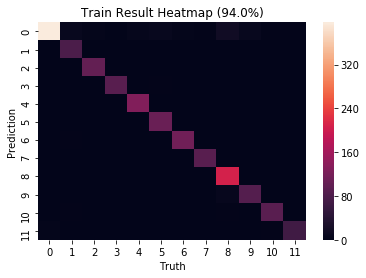

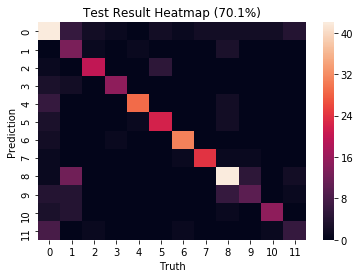

In [0]:
%matplotlib inline
import seaborn as sns
def compute_classification_accuracy(trail):
    accs = []
    loss = []
    heatmap = np.zeros((12, 12))
    
    for x_local, y_local in load_data('acc_%s' % trail):
        x_local = np.reshape(x_local, (batch_size, nb_steps, nb_image_width, nb_image_height, 1))
        y_local = to_categorical(y_local)

        res = model.predict(
                x_local,
                # y_local,
                batch_size=keras_batch_size,
                verbose=0
        )
        y_hat = np.array([np.argmax(res[i]) for i in range(batch_size)])
        y = np.array([np.argmax(y_local[i]) for i in range(batch_size)])
        
        accs.append(np.mean(y == y_hat))
        
        for i in range(y_local.shape[0]):
            heatmap[y[i], y_hat[i]] += 1
    return accs, heatmap

def print_and_plot_accuracy_metrics():
    accs_train, heatmap_train = compute_classification_accuracy('train')
    accs_test, heatmap_test = compute_classification_accuracy('test')

    print("Train accuracy: %f" % (np.mean(np.array(accs_train))))
    print("Test accuracy: %f" % (np.mean(np.array(accs_test))))

    sns.heatmap(heatmap_train)
    plt.title('Train Result Heatmap (%.1f%%)' % (np.mean(np.array(accs_train))*100))
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()

    sns.heatmap(heatmap_test)
    plt.title('Test Result Heatmap (%.1f%%)' % (np.mean(np.array(accs_test))*100))
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()

print_and_plot_accuracy_metrics()